# Fraud Detection

Due to the lack of public datasets available on financial services and specifically in mobile money transactions. It is interesting to many to analyze fraud detection in this domain. Therefore, PaySim wich is a financial mobile money generator based on the orginial dataset. It uses data from private sources to generate synthetic dataset the resembles the operational transactions. PaySim's transactiona are extracted from one months finacial logs from a mobile financial services company in an African country. 


This dataset is scaled down to 1/4 of the original dataset

## Import Data

In [165]:
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew, boxcox
# import tensorflow as tf
# import seaborn as sns
# from pylab import rcParams
# from sklearn.model_selection import train_test_split
# from keras.models import Model, load_model
# from keras.layers import Input, Dense
# from keras.callbacks import ModelCheckpoint, TensorBoard
# from keras import regularizers
sns.set(palette='husl', font_scale=1.20)

In [3]:
#Import the dataset
df = pd.read_csv('/Users/EshaSomavarapu/Desktop/PaySim.csv')

In [76]:
# Look at what is in our dataset
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [77]:
#Lets check to see if have any missing values
df.isnull().values.any()

False

In [78]:
#Explore the data types and statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05 

## Exploratory Data Analysis

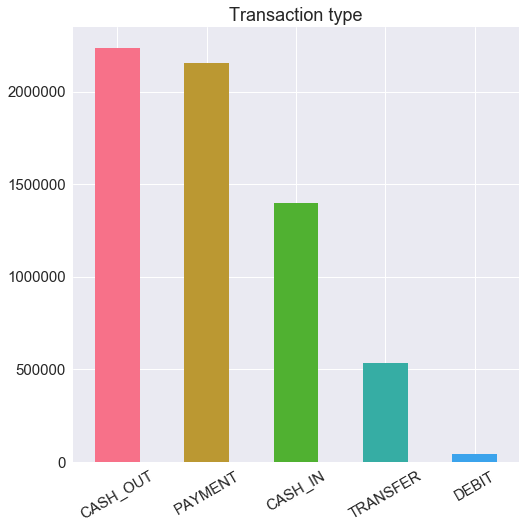

In [108]:
# Lets take a look at different kinds of transactions
df.type.value_counts()

f, ax = plt.subplots(1, 1, figsize=(6, 6))
g = df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8), rot=30)

__Initial Hypothesis__:


It stands out to me that majority of the transactions are __CASH OUT__ and __PAYMENT__. Lets use indicator variables __isFraud__ and __isFlaggedFraud__ to identify which transactions are fraudulent.




type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64


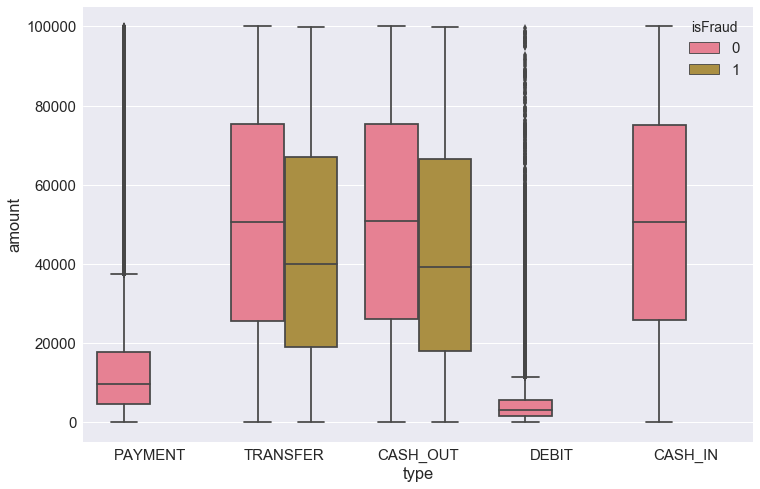

In [99]:
# Using Type of transaction and isFraud, let's calcualte which categories had fraudulent activities

print(df.groupby(['type', 'isFraud']).count()['step'])

plt.figure(figsize=(12,8))
g = sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df[df.amount < 1e5])

Therefore according to our initial hypothesis, we can see that variable __CASH OUT__ and additionally, we can detect that __TRANSFER__ have fraudulent activities.

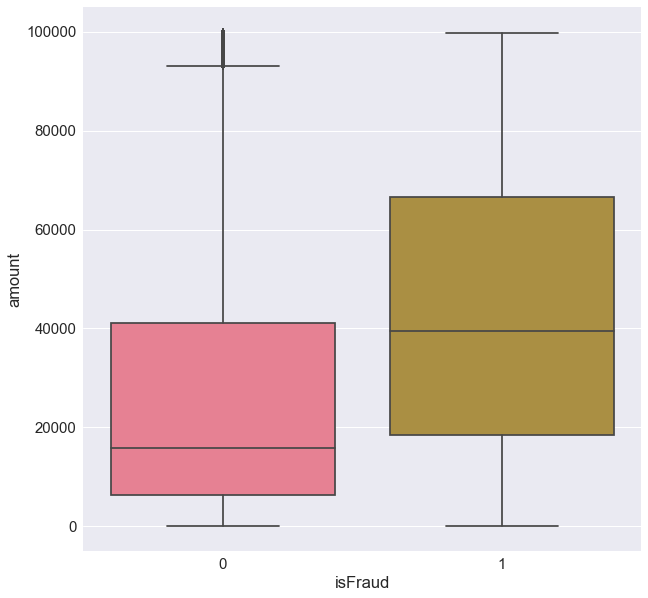

In [102]:
plt.figure(figsize=(10,10))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

Using the box plot above, we can see that fraudulent activities have large amounts being transfered or for cashed out.

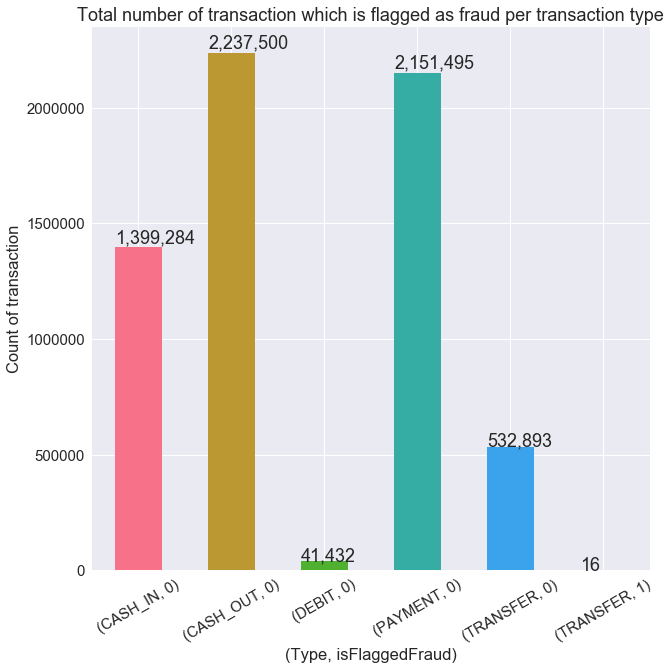

In [112]:
plt.figure(figsize=(10,10))
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar', rot=30)
ax.set_title("Total number of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

In [156]:
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# # tmp = df.loc[(df.type == 'TRANSFER'), :]

# a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
# axs[0][0].set_yscale('log')
# b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
# axs[0][1].set(ylim=(0, 0.5e8))
# c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
# axs[1][0].set(ylim=(0, 3e7))
# d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])

In [117]:
# Let's only look at data with Transcation type - transfer and cash out
# Drop varibales such as some columns like nameDest, nameOrig, step, isFlaggedFraud


tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)

# Dummy code Type - column
# Transfer = 1, CashOut = 0 called it type_num

a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_dum'] = b.argmax(1)

tmp.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_dum
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


## Transformations

Text(0.5,0,'old balance destinated')

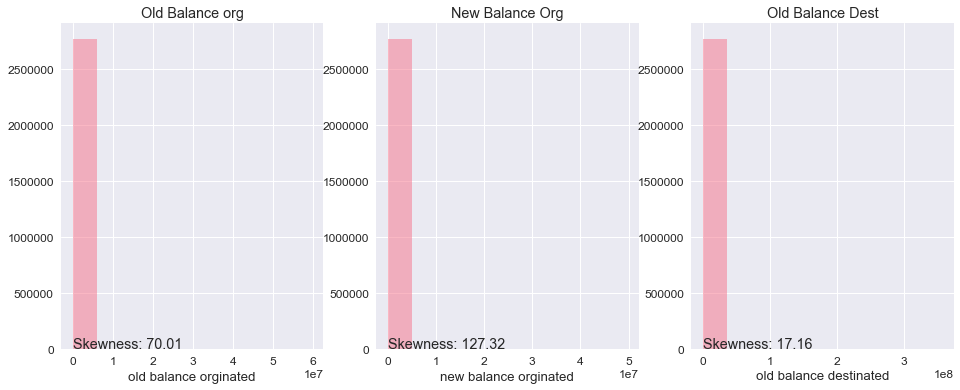

In [161]:

# Let's check skewness of our variables and if they require transformations
figure = plt.figure(figsize=(16, 6))
figure.add_subplot(131) 

plt.hist(tmp['oldbalanceOrg'], alpha = 0.5)
plt.text(100,10000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))
plt.title('Old Balance org')
plt.xlabel('old balance orginated')

figure.add_subplot(132)
plt.hist(tmp['newbalanceOrig'], alpha = 0.5)
plt.text(100,10000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))
plt.title('New Balance Org')
plt.xlabel('new balance orginated')

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest'], alpha = 0.5)
plt.text(100,10000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))
plt.title('Old Balance Dest')
plt.xlabel('old balance destinated')

Text(0.5,0,'amount')

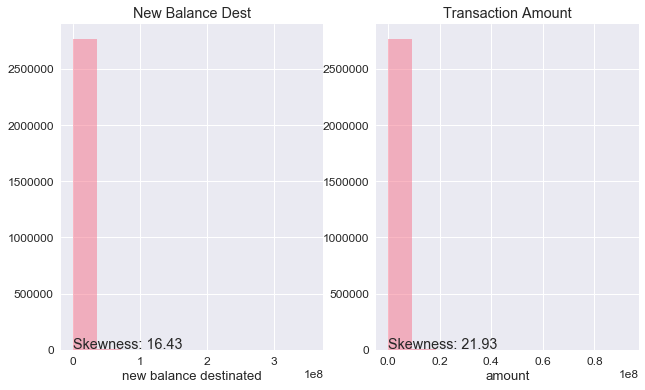

In [152]:
figure = plt.figure(figsize=(16, 6))
figure.add_subplot(131) 

plt.hist(tmp['newbalanceDest'], alpha = 0.5)
plt.text(100,10000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))
plt.title('New Balance Dest')
plt.xlabel('new balance destinated')

figure.add_subplot(132) 
plt.hist(tmp['amount'], alpha = 0.5)
plt.text(100,10000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))
plt.title('Transaction Amount')
plt.xlabel('amount')

All of our varaibles __newbalanceDest__ , __Amount__,__oldbalanceorig__, __newbalanceorig__, __oldbalanceDest__ are highly skewed. Therefore, it indicates that these variables need to be transformed using BoxCox.

### Box Cox Transformation

Text(2,100000,'Skewness: 0.15')

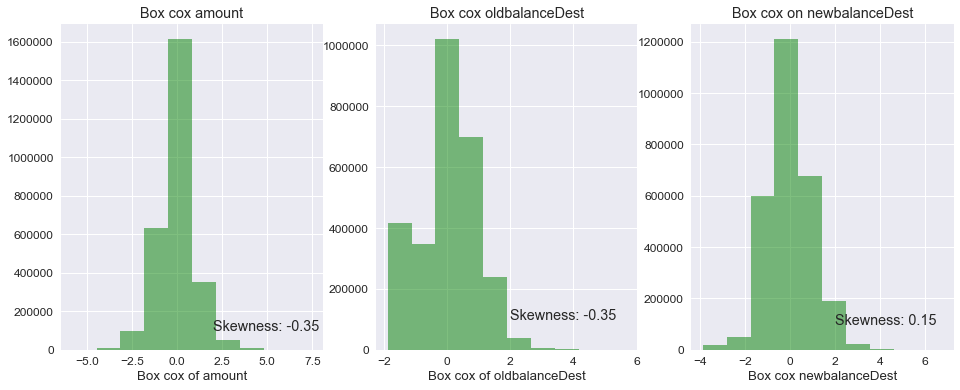

In [188]:
from sklearn import preprocessing

figure = plt.figure(figsize=(16, 6))

#Transform Amount
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])
figure.add_subplot(131) 
plt.hist(tmp['amount_boxcox'], facecolor = 'green', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Box cox amount")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

#Transform oldbalanceDest
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])
figure.add_subplot(132)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'green', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

#Transform newbalanceDest
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])
figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'green', alpha=0.5)
plt.xlabel("Box cox newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))


Text(2,100000,'Skewness: 2.69')

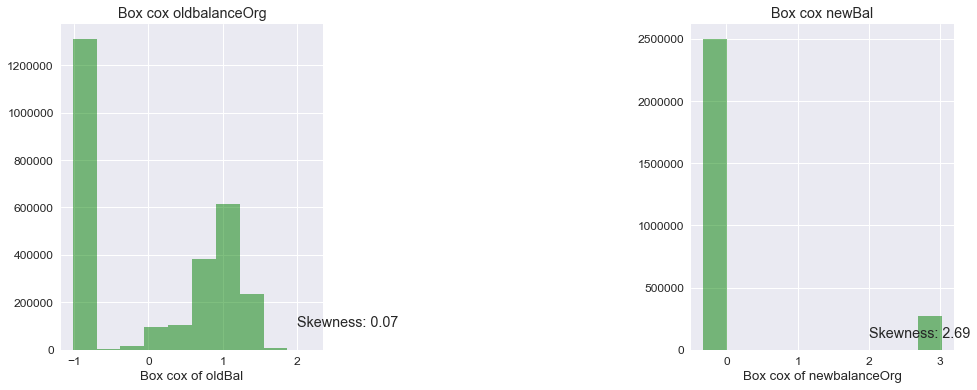

In [194]:
figure = plt.figure(figsize=(16, 6))

#Transform oldbalanceOrg
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])
figure.add_subplot(131)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'green', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

#Transform newbalanceOrg

tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])
figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'green', alpha=0.5)
plt.xlabel("Box cox of newbalanceOrg")
plt.title("Box cox newBal")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))


After applying Box Cox transformation skewness of our numeric variables is much better than before transformation. 

Lets Check what how many observations are fraudulent and their percentages

In [235]:
print('Total number of observations:', tmp.shape[0], '| ' 'Percentage: {0:.0f}%'.format(len(tmp)/len(tmp)*100))
print('------------------------------------------------------------')
print('Normal Transactions:', len(tmp[tmp.isFraud == 0]),'| ' 'Percentage: {0:.1f}%'.format(len(tmp[tmp.isFraud == 0])/len(tmp)*100))
print('------------------------------------------------------------')
print('Fraud Transactions:', len(tmp[tmp.isFraud == 1]), '| ' 'Percentage:{0:.1f}%'.format(len(tmp[tmp.isFraud == 1])/len(tmp)*100))

Total number of observations: 2770409 | Percentage: 100%
------------------------------------------------------------
Normal Transactions: 2762196 | Percentage: 99.7%
------------------------------------------------------------
Fraud Transactions: 8213 | Percentage:0.3%


In [305]:
# tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.ix[:, tmp.columns != 'isFraud']
y = tmp.ix[:, tmp.columns == 'isFraud']

number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  16426


## Logistic Regression

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))

Number transactions train dataset:  2,077,806
Number transactions test dataset:  692,603
Total number of transactions:  2,770,409

Number transactions train dataset:  11,498
Number transactions test dataset:  4,928
Total number of transactions:  16,426


In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(len(y_train_data), kfoldnum,shuffle=False) 

    results_table = pd.DataFrame(index = range(len(c_array),3), columns = ['C_parameter','Mean recall score', 'Mean precision score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("Iteration {}: recall score = {:.4f}, precision score = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        j += 1
        print('')
        print('Mean recall score {:.4f}'.format(np.mean(recall_accs)))
        print('Mean precision score {:.4f}'.format(np.mean(precision_accs)))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [311]:
c_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
k_fold = 5
best_c = 0.001

In [317]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.97827136649


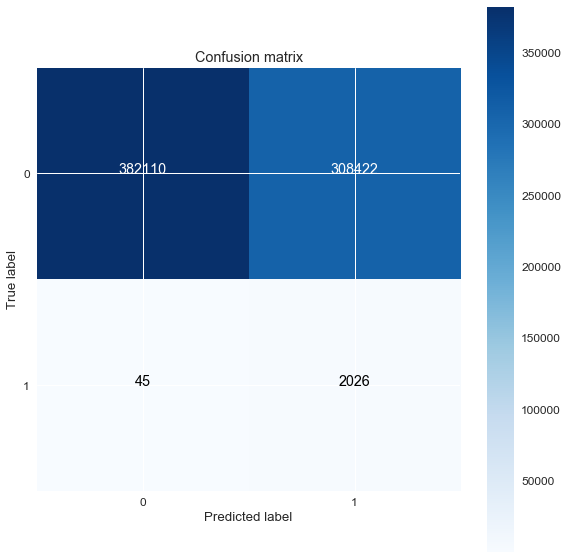

In [326]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

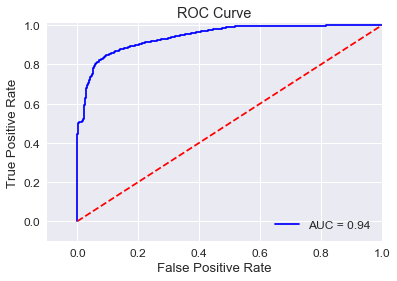

------------------------------------------------------------------------------
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[-0.32]
[[ 0.    0.08  0.64  0.    0.   -0.28]]
['type_dum', 'amount_boxcox', 'oldbalanceOrg_boxcox', 'newbalanceOrg_boxcox', 'oldbalanceDest_boxcox', 'newbalanceDest_boxcox']


In [328]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.figure(figsize=(8, 10))

print('------------------------------------------------------------------------------')
print(lr)
print(lr.intercept_ )
print(lr.coef_)
print(X.columns.tolist())

Logistic Regression equation:

    -0.32 + 0*type_dum + 0.08*amount - 0.28*newBalanceDest
    
ODDS Ratio for Fraud Vs. Non-Fraud transactions:

8% of amount of transaction, and 28% of Destination of transaction are more likely to be fraudlent transactions

## Building a Autoencoder for anomoly detection


In [254]:
RANDOM_SEED = 42
X_train, X_test = train_test_split(tmp, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.isFraud == 0]
X_train = X_train.drop(['isFraud'], axis=1)
y_test = X_test['isFraud']
X_test = X_test.drop(['isFraud'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(2209760, 6)

array([[ 0.        ,  0.3870222 , -1.01972004, -0.33112829,  0.27497501,
         0.10998916],
       [ 0.        , -0.61012485,  0.91056156, -0.33112829, -0.03688957,
        -0.43418375],
       [ 0.        ,  0.05283782, -1.01972004, -0.33112829,  0.02624384,
        -0.24554974],
       ..., 
       [ 0.        , -0.10691274,  0.76305447, -0.33112829,  0.37374892,
         0.16088397],
       [ 0.        , -0.33307558,  1.12777585, -0.33112829, -0.5590713 ,
        -0.94651224],
       [ 0.        , -0.57758705,  1.26068889,  3.02057605,  0.57700493,
         0.39936463]])

In [256]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [262]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 2209760 samples, validate on 554082 samples
Epoch 1/100
2209760/2209760 [==============================] - 308s - loss: 0.3513 - acc: 0.9847 - val_loss: 0.3557 - val_acc: 0.9907
Epoch 2/100
2209760/2209760 [==============================] - 352s - loss: 0.3513 - acc: 0.9848 - val_loss: 0.3557 - val_acc: 0.9875
Epoch 3/100
2209760/2209760 [==============================] - 334s - loss: 0.3514 - acc: 0.9850 - val_loss: 0.3557 - val_acc: 0.9891
Epoch 4/100
2209760/2209760 [==============================] - 255s - loss: 0.3514 - acc: 0.9849 - val_loss: 0.3565 - val_acc: 0.9723
Epoch 5/100
2209760/2209760 [==============================] - 255s - loss: 0.3513 - acc: 0.9853 - val_loss: 0.3560 - val_acc: 0.9655
Epoch 6/100
2209760/2209760 [==============================] - 255s - loss: 0.3514 - acc: 0.9850 - val_loss: 0.3557 - val_acc: 0.9875
Epoch 7/100
2209760/2209760 [==============================] - 255s - loss: 0.3513 - acc: 0.9851 - val_loss: 0.3558 - val_acc: 0.9872
Epoch 8/1

In [263]:
autoencoder = load_model('model.h5')

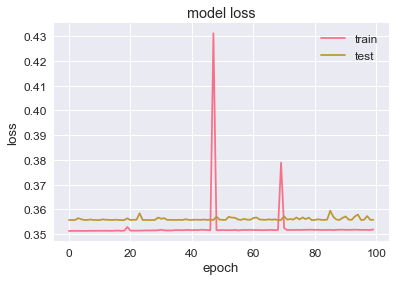

In [264]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [265]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,554082.000000,554082.000000
mean,0.355326,0.002971
std,0.442091,0.054423
min,0.000008,0.000000
25%,0.126108,0.000000
50%,0.193786,0.000000
75%,0.433962,0.000000
max,7.847793,1.000000


Text(0.5,1,'Reconstruction error for Normal')

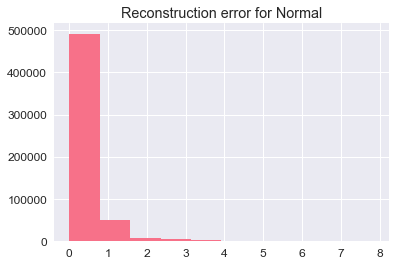

In [329]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.title('Reconstruction error for Normal')

Text(0.5,1,'Reconstruction Error for Fraud')

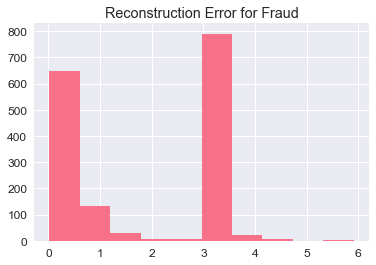

In [330]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.title('Reconstruction Error for Fraud')

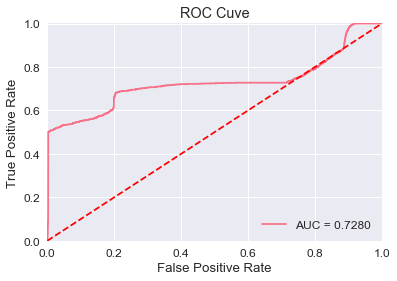

In [297]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC Cuve')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [295]:
threshold = 1.3

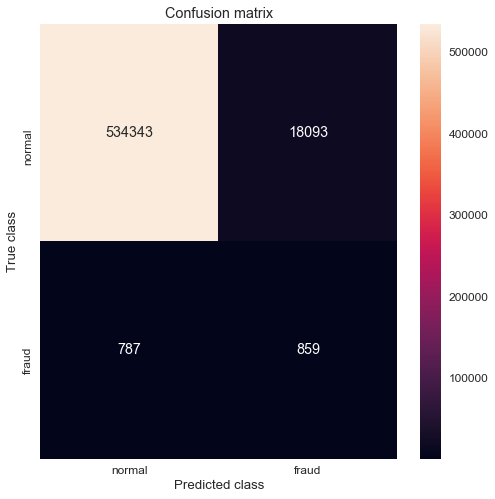

In [296]:
labels = ['normal', 'fraud']
normal = df[df.isFraud == 0]
frauds = df[df.isFraud == 1]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

For Deep Learning Autoencoder, our AUC = 0.72, we would like our curve to be closer to the top-left edge. It is best, if we use logistic regression where AUC = 0.94 to predict if a transaction is fraudulent or not.